In [1]:
#Due to the terms of service the data from PJM cannot be redistributed. This will demonstrate how I merged the datasets however.
#imports
import pandas as pd

#create a function that will read in each csv in the Data/ directory then merge on datetime_beginning_utc
def read_and_merge(region):
    """
    Read in each csv then merge on datetime_beginning_utc
    """
    #read in each csv
    df = pd.read_csv('Data/hrl_load_metered.csv')
    for i in range(1,6):
        df_temp = pd.read_csv(f'Data/hrl_load_metered ({i}).csv')
        #merge on datetime_beginning_utc
        df = pd.concat([df, df_temp], ignore_index=True)
    #return only load_area = region
    return df[df['load_area'] == region]

#make the data set and save to csv
#df = read_and_merge('AECO')
#df.to_csv('Data/AECO.csv', index=False)


Now moving to the main project

In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [3]:
#read in the data
data = pd.read_csv('Data/AECO.csv')
data.head()
print(data.keys())

Index(['datetime_beginning_utc', 'datetime_beginning_ept', 'nerc_region',
       'mkt_region', 'zone', 'load_area', 'mw', 'is_verified'],
      dtype='object')


In [4]:
#For a time series we really only care about the date and the value of the time series.
#We can drop the other columns.
columns = ['datetime_beginning_utc', 'mw']
df = data[columns]
#Rename the mw column to load
df = df.rename(columns={'mw': 'load', 'datetime_beginning_utc': 'date'})
#Convert the date column to a date
df['date'] = pd.to_datetime(df['date'])
#Sort the dataframe by date
df = df.sort_values(by='date')
#Set the index to the date column
df = df.set_index('date')
#Convert the index to datetime
df.tail()


,load
date,
2023-08-01 23:00:00,1583.920
2023-08-02 00:00:00,1522.854
2023-08-02 01:00:00,1430.097
2023-08-02 02:00:00,1313.167
2023-08-02 03:00:00,1147.869


<Axes: title={'center': 'Date vs. Load'}, xlabel='date', ylabel='load'>

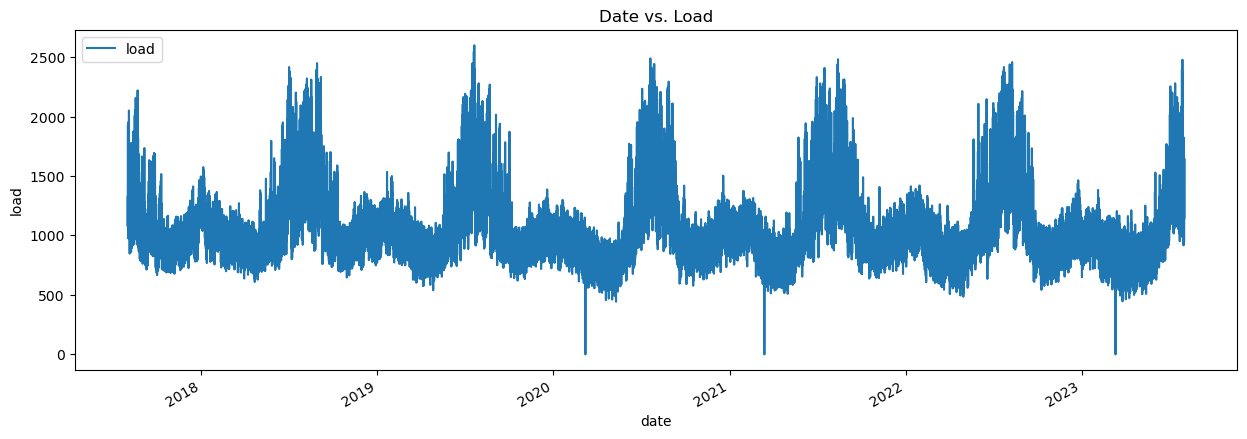

In [5]:
df.plot(figsize=(15,5), title = 'Date vs. Load', xlabel= 'date', ylabel = 'load')

<Axes: title={'center': 'Load Values < 100'}, xlabel='date'>

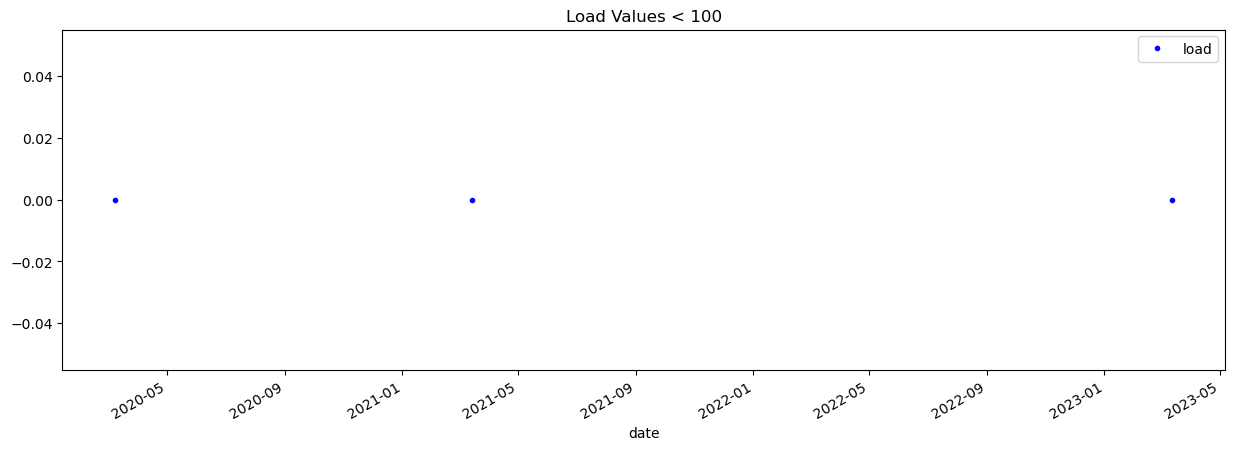

In [6]:
#We notice that we potentially have outliers where the load hits 0, and this may be a blackout or sensor error. We don't want our model to learn these features.
#Plot all valus in the load column that are less than 100
df[df['load'] < 100].plot(y='load', figsize=(15, 5), style = 'b.', title='Load Values < 100', label='load')

<Axes: title={'center': 'Date vs. Load'}, xlabel='date', ylabel='load'>

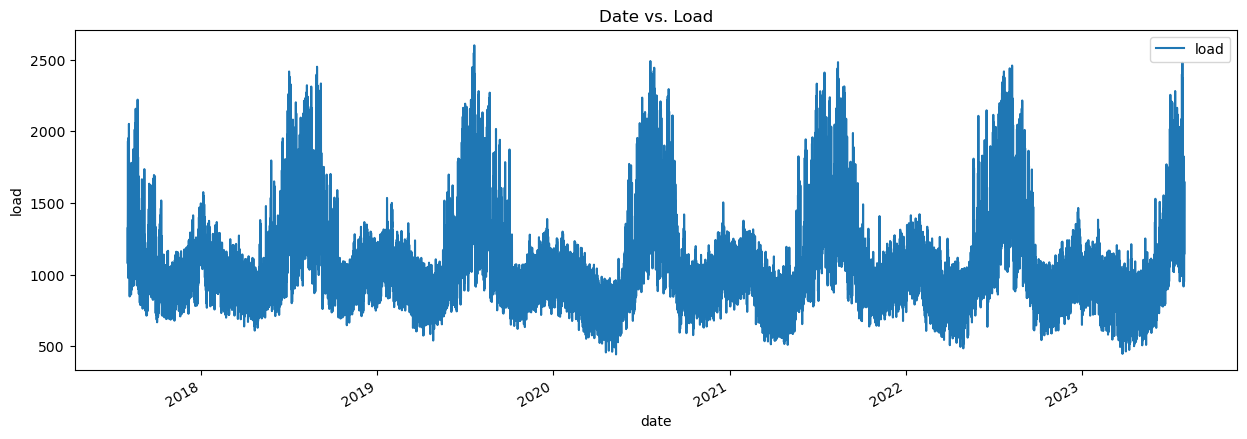

In [7]:
#This demonstrates that it is most likely that these 3 values of 0 are not true data, so we will drop them
df = df.query('load > 0').copy()
df.plot(figsize=(15,5), title = 'Date vs. Load', xlabel= 'date', ylabel = 'load')

In [8]:
#We are planning to use XGBoost for this problem. We will have to create features for the model to train on.
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofweek'] = df.index.dayofweek
df['weekend'] = ((df['dayofweek'] == 5) | (df['dayofweek'] == 6)).astype(int)
df['quarter'] = df.index.quarter
df['holiday'] = df.index.isin(calendar().holidays()).astype(int)
#df['week'] = df.index.isocalendar().week

In [9]:
#We can see a periodicity of about a year, so a way to improve our model would be to include a lag feature 
load_map = df['load'].to_dict()
#df['lag'] = (df.index - pd.Timedelta(days=364)).map(load_map)
df.describe()

,load,hour,day,month,year,dayofweek,weekend,quarter,holiday
count,52701.000000,52701.000000,52701.000000,52701.000000,52701.000000,52701.000000,52701.000000,52701.000000,52701.000000
mean,1062.449966,11.500313,15.694617,6.527523,2020.083718,3.001044,0.285934,2.510104,0.001195
std,319.092642,6.922325,8.814966,3.445238,1.776404,2.000365,0.451862,1.115935,0.034555
min,442.855000,0.000000,1.000000,1.000000,2017.000000,0.000000,0.000000,1.000000,0.000000
25%,849.561000,5.000000,8.000000,4.000000,2019.000000,1.000000,0.000000,2.000000,0.000000
50%,982.149000,12.000000,16.000000,7.000000,2020.000000,3.000000,0.000000,3.000000,0.000000
75%,1170.373000,18.000000,23.000000,10.000000,2022.000000,5.000000,1.000000,4.000000,0.000000
max,2599.326000,23.000000,31.000000,12.000000,2023.000000,6.000000,1.000000,4.000000,1.000000


In [10]:
#Split the data into a training set and a testing set.
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3, test_size=365*24, gap=24)

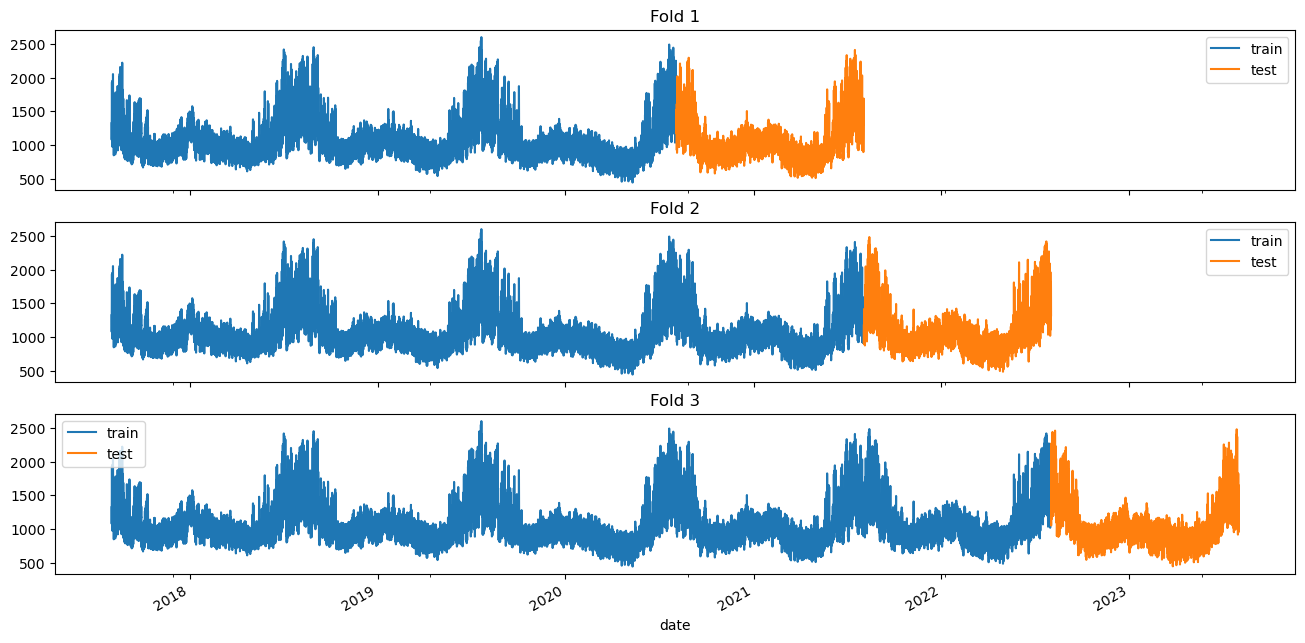

In [11]:
#Plot each of the splits of the dataset as a separate subplot, add a title to each subplot, and display the plots.
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16,8))
fold = 0
for train_index, test_index in splits.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    train['load'].plot(legend=True, label='train', title='Fold {}'.format(fold+1), ax=axs[fold])
    test['load'].plot(legend=True, label='test', ax=axs[fold])
    fold+=1
plt.legend()
plt.show()



In [12]:
#Print the types of the columns
print(df.dtypes)

load         float64
hour           int64
day            int64
month          int64
year           int64
dayofweek      int64
weekend        int32
quarter        int64
holiday        int32
dtype: object


In [13]:
#Train the model on all the folds
from sklearn.metrics import mean_squared_error
fold = 0 
preds = []
scores = []
for train_index, test_index in splits.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    x_train = train.drop(['load'], axis=1)
    y_train = train['load']
    x_test = test.drop(['load'], axis=1)
    y_test = test['load']
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth = 3, objective = 'reg:squarederror', early_stopping_rounds=5, random_state=2)
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
    preds.append(model.predict(x_test))
    scores.append(mean_squared_error(y_test, model.predict(x_test), squared=False))



In [14]:
#Print out the scores 
for i in range(len(scores)):
    print(f'RMSE Score on fold {i} set: {scores[i]:0.2f}')
untuned_rmse = scores[2]
# Find and print mean of our RMSE scores
print(f'Mean RMSE Score on all folds: {np.mean(scores):0.2f}')


RMSE Score on fold 0 set: 171.52
RMSE Score on fold 1 set: 161.16
RMSE Score on fold 2 set: 154.58
Mean RMSE Score on all folds: 162.42


In [15]:
#Now we try hyper parameter tuning. We will use GridSearchCV to find the best parameters for our model.
#We will use the same model as before, but we will try to find the best parameters for it.
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}
tuning_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=tuning_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=0)
# Perform grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
error = mean_squared_error(y_test, model.predict(x_test), squared=False)



Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 3000}


In [16]:
#Now that we know what our best hyperparameters are, we can also try boosting on our model
fold = 0 
preds = []
scores = []
for train_index, test_index in splits.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    x_train = train.drop(['load'], axis=1)
    y_train = train['load']
    x_test = test.drop(['load'], axis=1)
    y_test = test['load']

    preds.append(model.predict(x_test))
    scores.append(mean_squared_error(y_test, model.predict(x_test), squared=False))
#Print out the scores 
for i in range(len(scores)):
    print(f'RMSE Score on fold {i} set: {scores[i]:0.2f}')
# Find and print mean of our RMSE scores
print(f'Mean RMSE Score on all folds: {np.mean(scores):0.2f}')

RMSE Score on fold 0 set: 161.71
RMSE Score on fold 1 set: 156.99
RMSE Score on fold 2 set: 154.58
Mean RMSE Score on all folds: 157.76


In [17]:
#Compare Tuned and Untuned XGBoost Algorithm for Regression
model = xgb.XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth = 3, objective = 'reg:squarederror', random_state=2, booster='gbtree',eval_metric='rmse')
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Tuned RMSE: %f" % (rmse))
print("Untuned RMSE: %f" % (untuned_rmse))

Tuned RMSE: 150.407239
Untuned RMSE: 154.579029


In [18]:
#Predictions for the future
#Retrain our model on the full data set
x = df.drop('load', axis=1)
y = df['load']
model = xgb.XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth = 3, objective = 'reg:squarederror', random_state=2, booster='gbtree',eval_metric='rmse')
model.fit(x, y, verbose=False)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

<Axes: >

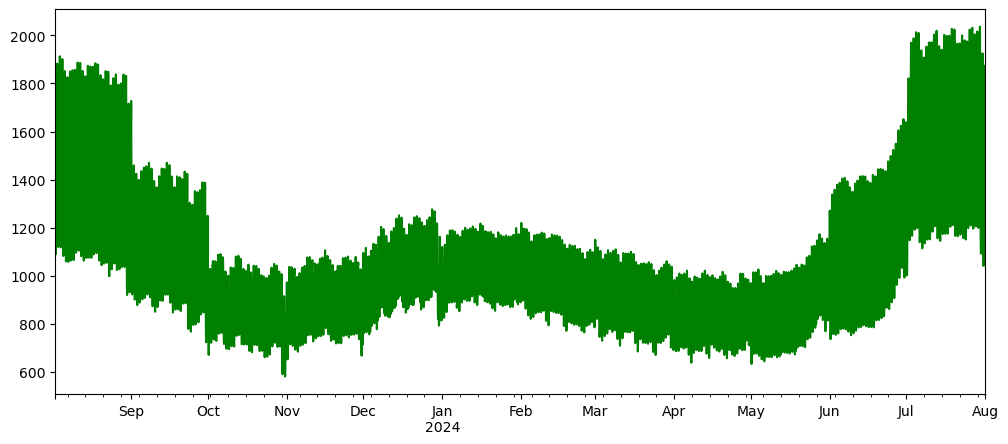

In [19]:
#Create x for the future 
future = pd.date_range(df.index[-1], '2024-08-01', freq ='1h')
x_future = pd.DataFrame(index = future)
x_future['hour'] = x_future.index.hour
x_future['day'] = x_future.index.day
x_future['month'] = x_future.index.month
x_future['year'] = x_future.index.year
x_future['dayofweek'] = x_future.index.dayofweek
x_future['weekend'] = ((x_future['dayofweek'] == 5) | (x_future['dayofweek'] == 6)).astype(int)
x_future['quarter'] = x_future.index.quarter
x_future['holiday'] = x_future.index.isin(calendar().holidays()).astype(int)
x_future['predictions'] = model.predict(x_future)
x_future['predictions'].plot(figsize=(12,5), color='green')

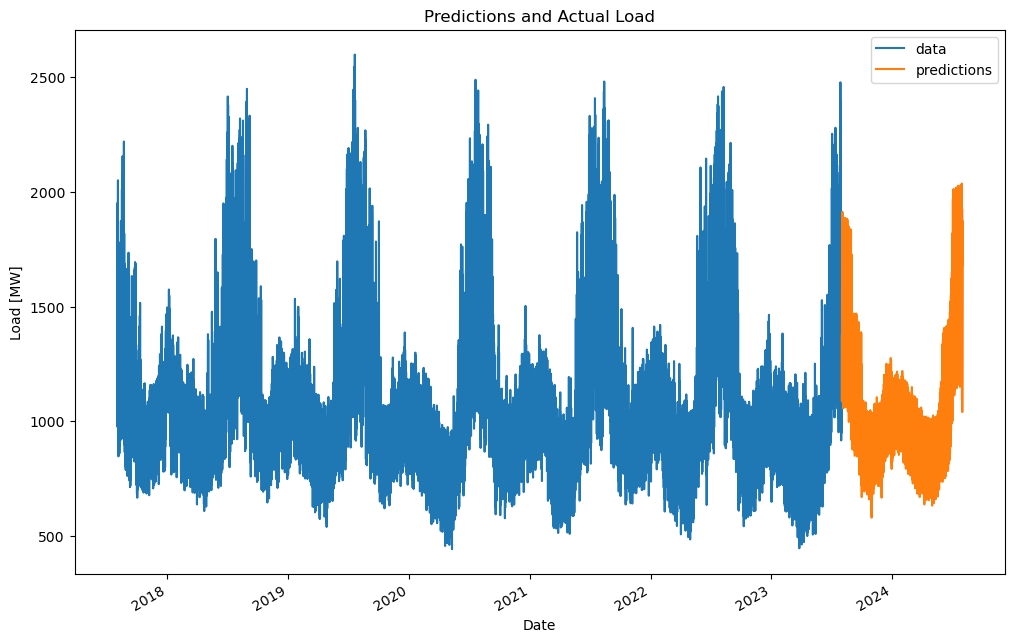

In [20]:
#Plot x and x_future on the same graph
df['load'].plot(figsize=(12,8), label = 'data')
x_future['predictions'].plot(figsize=(12,8), label = 'predictions')
plt.legend()
plt.title('Predictions and Actual Load')
plt.xlabel('Date')
plt.ylabel('Load [MW]')
plt.show()


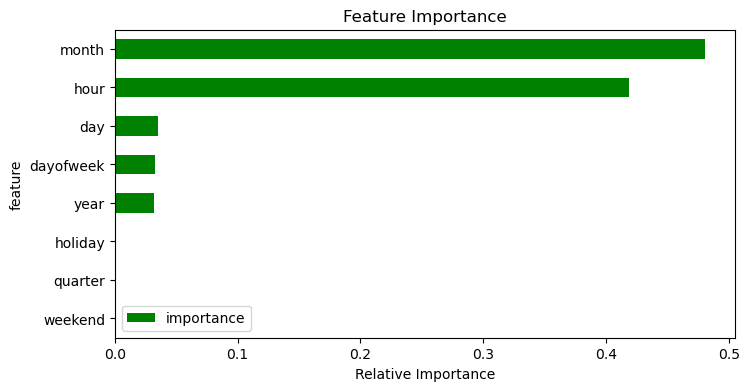

In [21]:
#Make a graph of the feature importances

feature_importance = model.feature_importances_
features = x.columns
feature_frame = pd.DataFrame({'importance': feature_importance, 'feature': features})
feature_frame.sort_values(by='importance', inplace=True)
feature_frame.set_index('feature', inplace=True, drop=True)
feature_frame.plot(kind='barh', figsize=(8, 4), color='green')
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.show()
